# Experiments master thesis ETH

## Marginal likehood optimisation

In [7]:
#!pip3 install backpack-for-pytorch
#!pip3 install asdfghjkl
!pip3 install laplace-torch
#!pip3 install laplace

In [13]:
!python3 -m pip install laplace

Processing /home/infres/slabbi/.cache/pip/wheels/08/2f/2b/65cc56a86a26c2e0a3f27ad7ffc8f2f95642d9ac7be7bcb7a7/laplace-0.1-py3-none-any.whl


In [7]:
from laplace-torch import KronLaplace

SyntaxError: invalid syntax (3555730746.py, line 1)

In [5]:
import laplace

In [1]:
import sys
sys.path
sys.path.append('/home/infres/slabbi/Master_thesis/lib/python3.8/site-packages')

In [5]:
from copy import deepcopy
import numpy as np
import torch
from torch.nn.utils.convert_parameters import vector_to_parameters
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingLR
from torch.nn import CrossEntropyLoss, MSELoss
from torch.nn.utils import parameters_to_vector
from torch.distributions import Normal
import matplotlib.pyplot as plt
import math
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as td
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange

from laplace-torch import KronLaplace
from laplace.curvature import AsdlGGN


GB_FACTOR = 1024 ** 3




def expand_prior_precision(prior_prec, model):
    theta = parameters_to_vector(model.parameters())
    device, P = theta.device, len(theta)
    assert prior_prec.ndim == 1
    if len(prior_prec) == 1:  # scalar
        return torch.ones(P, device=device) * prior_prec
    elif len(prior_prec) == P:  # full diagonal
        return prior_prec.to(device)
    else:
        return torch.cat([delta * torch.ones_like(m).flatten() for delta, m
                          in zip(prior_prec, model.parameters())])




def get_prior_hyperparams(prior_prec_init, prior_structure, H, P, device):
    log_prior_prec_init = np.log(prior_prec_init)
    if prior_structure == 'scalar':
        log_prior_prec = log_prior_prec_init * torch.ones(1, device=device)
    elif prior_structure == 'layerwise':
        log_prior_prec = log_prior_prec_init * torch.ones(H, device=device)
    elif prior_structure == 'diagonal':
        log_prior_prec = log_prior_prec_init * torch.ones(P, device=device)
    else:
        raise ValueError(f'Invalid prior structure {prior_structure}')
    log_prior_prec.requires_grad = True
    return log_prior_prec




def valid_performance(model, test_loader, likelihood, criterion, device):
    N = len(test_loader.dataset)
    perf = 0
    nll = 0
    for X, y in test_loader:
        X, y = X.detach().to(device), y.detach().to(device)
        with torch.no_grad():
            f = model(X)
        if likelihood == 'classification':
            perf += (torch.argmax(f, dim=-1) == y).sum() / N
        elif likelihood == 'heteroscedastic_regression':
            perf += (y.squeeze() + 0.5 * f[:, 0] / f[:, 1]).square().sum() / N
        else:
            perf += (f - y).square().sum() / N
        nll += criterion(f, y) / len(test_loader)
    return perf.item(), nll.item()




def get_scheduler(scheduler, optimizer, train_loader, n_epochs, lr, lr_min):
    n_steps = n_epochs * len(train_loader)
    if scheduler == 'exp':
        min_lr_factor = lr_min / lr
        gamma = np.exp(np.log(min_lr_factor) / n_steps)
        return ExponentialLR(optimizer, gamma=gamma)
    elif scheduler == 'cos':
        return CosineAnnealingLR(optimizer, n_steps, eta_min=lr_min)
    else:
        raise ValueError(f'Invalid scheduler {scheduler}')




def get_model_optimizer(optimizer, model, lr, weight_decay=0):
    if optimizer == 'adam':
        return Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer == 'sgd':
        # fixup parameters should have 10x smaller learning rate
        is_fixup = lambda param: param.size() == torch.Size([1])  # scalars
        fixup_params = [p for p in model.parameters() if is_fixup(p)]
        standard_params = [p for p in model.parameters() if not is_fixup(p)]
        params = [{'params': standard_params}, {'params': fixup_params, 'lr': lr / 10.}]
        return SGD(params, lr=lr, momentum=0.9, weight_decay=weight_decay)
    else:
        raise ValueError(f'Invalid optimizer {optimizer}')




def gradient_to_vector(parameters):
    return parameters_to_vector([e.grad for e in parameters])




def vector_to_gradient(vec, parameters):
    return vector_to_parameters(vec, [e.grad for e in parameters])




def marglik_optimization(model,
                         train_loader,
                         valid_loader=None,
                         likelihood='classification',
                         prior_structure='layerwise',
                         prior_prec_init=1.,
                         sigma_noise_init=1.,
                         temperature=1.,
                         n_epochs=50,
                         lr=1e-3,
                         lr_min=None,
                         optimizer='Adam',
                         scheduler='cos',
                         n_epochs_burnin=0,
                         n_hypersteps=100,
                         marglik_frequency=1,
                         lr_hyp=1e-1,
                         lr_hyp_min=1e-1,
                         laplace=KronLaplace,
                         backend=AsdlGGN,
                         early_stopping=False):
    """Runs marglik optimization training for a given model and training dataloader.


    Parameters
    ----------
    model : torch.nn.Module
        torch model
    train_loader : DataLoader
        pytorch training dataset loader
    valid_loader : DataLoader
    likelihood : str
        'classification', 'regression', 'heteroscedastic_regression'
    prior_structure : str
        'scalar', 'layerwise', 'diagonal'
    prior_prec_init : float
        initial prior precision
    sigma_noise_init : float
        initial observation noise (for regression only)
    temperature : float
        factor for the likelihood for 'overcounting' data.
        Often required when using data augmentation.
    n_epochs : int
    lr : float
        learning rate for model optimizer
    lr_min : float
        minimum learning rate, defaults to lr and hence no decay
        to have the learning rate decay from 1e-3 to 1e-6, set
        lr=1e-3 and lr_min=1e-6.
    optimizer : str
        either 'adam' or 'sgd'
    scheduler : str
        either 'exp' for exponential and 'cos' for cosine decay towards lr_min
    n_epochs_burnin : int default=0
        how many epochs to train without estimating and differentiating marglik
    n_hypersteps : int
        how many steps to take on the hyperparameters when marglik is estimated
    marglik_frequency : int
        how often to estimate (and differentiate) the marginal likelihood
    lr_hyp : float
        learning rate for hyperparameters (should be between 1e-3 and 1)
    laplace : Laplace
        type of Laplace approximation (Kron/Diag/Full)
    backend : Backend
        AsdlGGN/AsdlEF or BackPackGGN/BackPackEF
    stochastic_grad : bool
    independent : bool
        whether to use independent functional laplace
    single_output : bool
        whether to use single random output for functional laplace
    kron_jac : bool
        whether to use kron_jac in the backend


    Returns
    -------
    lap : Laplace
        lapalce approximation
    model : torch.nn.Module
    margliks : list
    losses : list
    """
    if lr_min is None:  # don't decay lr
        lr_min = lr
    device = parameters_to_vector(model.parameters()).device
    N = len(train_loader.dataset)
    H = len(list(model.parameters()))
    P = len(parameters_to_vector(model.parameters()))
    best_model_dict = None


    # differentiable hyperparameters
    hyperparameters = list()
    # prior precision
    log_prior_prec = get_prior_hyperparams(prior_prec_init, prior_structure, H, P, device)
    hyperparameters.append(log_prior_prec)


    # set up loss (and observation noise hyperparam)
    if likelihood == 'classification':
        criterion = CrossEntropyLoss(reduction='mean')
        sigma_noise = 1
    elif likelihood == 'regression':
        criterion = MSELoss(reduction='mean')
        log_sigma_noise_init = np.log(sigma_noise_init)
        log_sigma_noise = log_sigma_noise_init * torch.ones(1, device=device)
        log_sigma_noise.requires_grad = True
        hyperparameters.append(log_sigma_noise)
    else:
        raise ValueError()


    # set up model optimizer and scheduler
    optimizer = get_model_optimizer(optimizer, model, lr)
    scheduler = get_scheduler(scheduler, optimizer, train_loader, n_epochs, lr, lr_min)


    n_steps = ((n_epochs - n_epochs_burnin) // marglik_frequency) * n_hypersteps
    hyper_optimizer = Adam(hyperparameters, lr=lr_hyp)
    hyper_scheduler = CosineAnnealingLR(hyper_optimizer, n_steps, eta_min=lr_hyp_min)


    losses = list()
    valid_perfs = list()
    valid_nlls = list()
    margliks = list()
    best_marglik = np.inf


    for epoch in range(1, n_epochs + 1):
        epoch_loss = 0
        epoch_perf = 0
        epoch_nll = 0
        epoch_log = dict(epoch=epoch)


        # standard NN training per batch
        torch.cuda.empty_cache()
        for X, y in train_loader:
            X, y = X.detach().to(device), y.to(device)
            optimizer.zero_grad()


            if likelihood == 'regression':
                sigma_noise = torch.exp(log_sigma_noise).detach()
                crit_factor = 1 / temperature / (2 * sigma_noise.square())
            else:
                crit_factor = 1 / temperature
            prior_prec = torch.exp(log_prior_prec).detach()
            delta = expand_prior_precision(prior_prec, model)


            f = model(X)


            theta = parameters_to_vector(model.parameters())
            loss = criterion(f, y) + (0.5 * (delta * theta) @ theta) / N / crit_factor
            loss.backward()
            optimizer.step()


            epoch_loss += loss.cpu().item() / len(train_loader)
            epoch_nll += criterion(f.detach(), y).item() / len(train_loader)
            if likelihood == 'regression':
                epoch_perf += (f.detach() - y).square().sum() / N
            elif likelihood == 'heteroscedastic_regression':
                epoch_perf += (y.squeeze() + 0.5 * f[:, 0] / f[:, 1]).square().sum() / N
            else:
                epoch_perf += torch.sum(torch.argmax(f.detach(), dim=-1) == y).item() / N
            scheduler.step()


        losses.append(epoch_loss)
        logging.info(f'MARGLIK[epoch={epoch}]: train. perf={epoch_perf:.2f}; loss={epoch_loss:.5f}; nll={epoch_nll:.5f}')
        optimizer.zero_grad(set_to_none=True)
        llr = scheduler.get_last_lr()[0]
        epoch_log.update({'train/loss': epoch_loss, 'train/nll': epoch_nll, 'train/perf': epoch_perf, 'train/lr': llr})
        # compute validation error to report during training
        if valid_loader is not None:
            with torch.no_grad():
                if likelihood == 'regression':
                    def val_criterion(f, y):
                        assert f.shape == y.shape
                        log_lik = Normal(loc=f, scale=sigma_noise).log_prob(y)
                        return -log_lik.mean()
                else:
                    val_criterion = criterion
                val_perf, val_nll = valid_performance(model, valid_loader, likelihood, val_criterion, device)
                valid_perfs.append(val_perf)
                valid_nlls.append(val_nll)
                logging.info(f'MARGLIK[epoch={epoch}]: valid. perf={val_perf:.2f}; nll={val_nll:.5f}.')
                epoch_log.update({'valid/perf': val_perf, 'valid/nll': val_nll})


        # only update hyperparameters every "Frequency" steps after "burnin"
        if (epoch % marglik_frequency) != 0 or epoch < n_epochs_burnin:
            continue


        # 1. fit laplace approximation
        torch.cuda.empty_cache()


        sigma_noise = 1 if likelihood != 'regression' else torch.exp(log_sigma_noise)
        prior_prec = torch.exp(log_prior_prec)
        lap = laplace(model, likelihood, sigma_noise=sigma_noise, prior_precision=prior_prec,
                        temperature=temperature, backend=backend)
        lap.fit(train_loader)
        # first optimize prior precision jointly with direct marglik grad
        margliks_local = list()
        for i in range(n_hypersteps):
            hyper_optimizer.zero_grad()
            sigma_noise = None if likelihood != 'regression' else torch.exp(log_sigma_noise)
            prior_prec = torch.exp(log_prior_prec)
            marglik = -lap.log_marginal_likelihood(prior_prec, sigma_noise) / N
            marglik.backward()
            margliks_local.append(marglik.item())
            hyper_optimizer.step()
            hyper_scheduler.step()


        marglik = margliks_local[-1]


        if likelihood == 'regression':
            epoch_log['hyperparams/sigma_noise'] = torch.exp(log_sigma_noise.detach()).cpu().item()
        epoch_log['train/marglik'] = marglik
        margliks.append(marglik)
        del lap


        # early stopping on marginal likelihood
        if early_stopping and (margliks[-1] < best_marglik):
            best_model_dict = deepcopy(model.state_dict())
            best_precision = deepcopy(prior_prec.detach())
            best_sigma = 1 if likelihood != 'regression' else deepcopy(sigma_noise.detach())
            best_marglik = margliks[-1]


    if early_stopping and (best_model_dict is not None):
        model.load_state_dict(best_model_dict)
        sigma_noise = best_sigma
        prior_prec = best_precision
    else:
        sigma_noise = 1 if sigma_noise is None else sigma_noise


    lap = laplace(model, likelihood, sigma_noise=sigma_noise, prior_precision=prior_prec,
                  temperature=temperature, backend=backend)
    lap.fit(train_loader)
    return lap, model, margliks

SyntaxError: invalid syntax (3981758977.py, line 21)

In [2]:
from PBB.pbb.models import ProbNNet4l, NNet4l, CNNet4l
import torchvision
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

BATCH_SIZE = 250
TRAIN_EPOCHS = 1
DELTA = 0.025
DELTA_TEST = 0.01
PRIOR = 'rand'
dropout_prob = 0.0
SIGMAPRIOR = 0.03
rho_prior = math.log(math.exp(SIGMAPRIOR)-1.0)
PMIN = 1e-5
KL_PENALTY = 0.1
LEARNING_RATE = 0.001
MOMENTUM = 0.95
LEARNING_RATE_PRIOR = 0.005
MOMENTUM_PRIOR = 0.99

net0 = NNet4l(dropout_prob=dropout_prob, device=device).to(device)

net = CNNet4l(dropout_prob=dropout_prob).to(device)

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4
)

lap, model, margliks = marglik_optimization(net,
                                             train_loader,
                                             valid_loader=test_loader,
                                             likelihood='classification',
                                             prior_structure='layerwise',
                                             prior_prec_init=1.,
                                             sigma_noise_init=1.,
                                             temperature=1.,
                                             n_epochs=1,
                                             lr=1e-3,
                                             lr_min=None,
                                             optimizer='adam',
                                             scheduler='cos',
                                             n_epochs_burnin=0,
                                             n_hypersteps=1,
                                             marglik_frequency=1,
                                             lr_hyp=1e-1,
                                             lr_hyp_min=1e-1,
                                             laplace=KronLaplace,
                                             backend=AsdlGGN,
                                             early_stopping=False)

False


C:\Users\Labbi\anaconda3\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


## PAC-Bayes with Backprop

False
-Prior: Test loss: 2.32062, Test err:  0.87920


  2%|▏         | 1/50 [00:51<42:23, 51.92s/it]

-Batch average epoch 0 results, Train obj: 0.21895, KL/n: 0.00014, NLL loss: 0.20759, Train 0-1 Error:  0.88340



  4%|▍         | 2/50 [01:59<48:51, 61.08s/it]

-Batch average epoch 1 results, Train obj: 0.21669, KL/n: 0.00038, NLL loss: 0.20141, Train 0-1 Error:  0.85970



  6%|▌         | 3/50 [02:52<45:02, 57.51s/it]

-Batch average epoch 2 results, Train obj: 0.21572, KL/n: 0.00053, NLL loss: 0.19843, Train 0-1 Error:  0.84929



  8%|▊         | 4/50 [04:10<50:21, 65.69s/it]

-Batch average epoch 3 results, Train obj: 0.21550, KL/n: 0.00067, NLL loss: 0.19648, Train 0-1 Error:  0.83406



 10%|█         | 5/50 [05:30<53:05, 70.78s/it]

-Batch average epoch 4 results, Train obj: 0.21522, KL/n: 0.00079, NLL loss: 0.19490, Train 0-1 Error:  0.82643



 12%|█▏        | 6/50 [06:47<53:16, 72.66s/it]

-Batch average epoch 5 results, Train obj: 0.21500, KL/n: 0.00092, NLL loss: 0.19344, Train 0-1 Error:  0.81712



 14%|█▍        | 7/50 [08:05<53:21, 74.44s/it]

-Batch average epoch 6 results, Train obj: 0.21587, KL/n: 0.00104, NLL loss: 0.19303, Train 0-1 Error:  0.81317



 16%|█▌        | 8/50 [08:57<47:07, 67.33s/it]

-Batch average epoch 7 results, Train obj: 0.21494, KL/n: 0.00116, NLL loss: 0.19108, Train 0-1 Error:  0.80171



 18%|█▊        | 9/50 [09:46<42:06, 61.61s/it]

-Batch average epoch 8 results, Train obj: 0.21540, KL/n: 0.00129, NLL loss: 0.19036, Train 0-1 Error:  0.79511



 20%|██        | 10/50 [10:36<38:45, 58.14s/it]

-Batch average epoch 9 results, Train obj: 0.21503, KL/n: 0.00143, NLL loss: 0.18887, Train 0-1 Error:  0.78828



 22%|██▏       | 11/50 [11:25<36:00, 55.39s/it]

-Batch average epoch 10 results, Train obj: 0.21554, KL/n: 0.00160, NLL loss: 0.18799, Train 0-1 Error:  0.78256



 24%|██▍       | 12/50 [12:16<34:16, 54.11s/it]

-Batch average epoch 11 results, Train obj: 0.21435, KL/n: 0.00181, NLL loss: 0.18528, Train 0-1 Error:  0.76571



 26%|██▌       | 13/50 [13:10<33:19, 54.04s/it]

-Batch average epoch 12 results, Train obj: 0.21397, KL/n: 0.00203, NLL loss: 0.18331, Train 0-1 Error:  0.75491



 28%|██▊       | 14/50 [14:03<32:12, 53.68s/it]

-Batch average epoch 13 results, Train obj: 0.21488, KL/n: 0.00231, NLL loss: 0.18227, Train 0-1 Error:  0.74618



 30%|███       | 15/50 [15:00<31:54, 54.69s/it]

-Batch average epoch 14 results, Train obj: 0.21352, KL/n: 0.00267, NLL loss: 0.17876, Train 0-1 Error:  0.72561



 32%|███▏      | 16/50 [15:50<30:08, 53.21s/it]

-Batch average epoch 15 results, Train obj: 0.21320, KL/n: 0.00309, NLL loss: 0.17595, Train 0-1 Error:  0.70748



 34%|███▍      | 17/50 [16:42<29:01, 52.78s/it]

-Batch average epoch 16 results, Train obj: 0.21347, KL/n: 0.00366, NLL loss: 0.17308, Train 0-1 Error:  0.68840



 36%|███▌      | 18/50 [17:46<29:58, 56.19s/it]

-Batch average epoch 17 results, Train obj: 0.21216, KL/n: 0.00440, NLL loss: 0.16817, Train 0-1 Error:  0.66015



 38%|███▊      | 19/50 [18:49<30:06, 58.27s/it]

-Batch average epoch 18 results, Train obj: 0.21163, KL/n: 0.00533, NLL loss: 0.16345, Train 0-1 Error:  0.63650



 40%|████      | 20/50 [19:53<29:56, 59.88s/it]

-Batch average epoch 19 results, Train obj: 0.20964, KL/n: 0.00657, NLL loss: 0.15652, Train 0-1 Error:  0.60149



 42%|████▏     | 21/50 [21:05<30:44, 63.62s/it]

-Batch average epoch 20 results, Train obj: 0.20711, KL/n: 0.00813, NLL loss: 0.14852, Train 0-1 Error:  0.56484



 44%|████▍     | 22/50 [22:00<28:27, 61.00s/it]

-Batch average epoch 21 results, Train obj: 0.20465, KL/n: 0.00997, NLL loss: 0.14030, Train 0-1 Error:  0.53324



 46%|████▌     | 23/50 [23:09<28:30, 63.35s/it]

-Batch average epoch 22 results, Train obj: 0.20308, KL/n: 0.01201, NLL loss: 0.13281, Train 0-1 Error:  0.50392



 48%|████▊     | 24/50 [24:00<25:53, 59.73s/it]

-Batch average epoch 23 results, Train obj: 0.19958, KL/n: 0.01419, NLL loss: 0.12392, Train 0-1 Error:  0.46926



 50%|█████     | 25/50 [25:02<25:10, 60.42s/it]

-Batch average epoch 24 results, Train obj: 0.19890, KL/n: 0.01626, NLL loss: 0.11810, Train 0-1 Error:  0.44509



 52%|█████▏    | 26/50 [26:00<23:54, 59.78s/it]

-Batch average epoch 25 results, Train obj: 0.19775, KL/n: 0.01811, NLL loss: 0.11278, Train 0-1 Error:  0.42449



 54%|█████▍    | 27/50 [27:01<22:59, 60.00s/it]

-Batch average epoch 26 results, Train obj: 0.19581, KL/n: 0.01983, NLL loss: 0.10735, Train 0-1 Error:  0.40748



 56%|█████▌    | 28/50 [27:54<21:14, 57.93s/it]

-Batch average epoch 27 results, Train obj: 0.19494, KL/n: 0.02138, NLL loss: 0.10331, Train 0-1 Error:  0.38725



 58%|█████▊    | 29/50 [28:44<19:25, 55.52s/it]

-Batch average epoch 28 results, Train obj: 0.19401, KL/n: 0.02271, NLL loss: 0.09984, Train 0-1 Error:  0.37695



 60%|██████    | 30/50 [29:40<18:33, 55.66s/it]

-Batch average epoch 29 results, Train obj: 0.19320, KL/n: 0.02379, NLL loss: 0.09702, Train 0-1 Error:  0.36623



 62%|██████▏   | 31/50 [30:31<17:12, 54.33s/it]

-Batch average epoch 30 results, Train obj: 0.19292, KL/n: 0.02477, NLL loss: 0.09487, Train 0-1 Error:  0.35466



 64%|██████▍   | 32/50 [31:29<16:40, 55.56s/it]

-Batch average epoch 31 results, Train obj: 0.19199, KL/n: 0.02562, NLL loss: 0.09252, Train 0-1 Error:  0.34644



 66%|██████▌   | 33/50 [32:27<15:56, 56.27s/it]

-Batch average epoch 32 results, Train obj: 0.19116, KL/n: 0.02642, NLL loss: 0.09037, Train 0-1 Error:  0.33575



 68%|██████▊   | 34/50 [33:20<14:44, 55.27s/it]

-Batch average epoch 33 results, Train obj: 0.19178, KL/n: 0.02697, NLL loss: 0.08980, Train 0-1 Error:  0.33337



 70%|███████   | 35/50 [34:12<13:34, 54.33s/it]

-Batch average epoch 34 results, Train obj: 0.19224, KL/n: 0.02742, NLL loss: 0.08930, Train 0-1 Error:  0.33190



 72%|███████▏  | 36/50 [35:10<12:56, 55.43s/it]

-Batch average epoch 35 results, Train obj: 0.19083, KL/n: 0.02787, NLL loss: 0.08742, Train 0-1 Error:  0.32274



 74%|███████▍  | 37/50 [36:07<12:05, 55.78s/it]

-Batch average epoch 36 results, Train obj: 0.19200, KL/n: 0.02827, NLL loss: 0.08755, Train 0-1 Error:  0.32341



 76%|███████▌  | 38/50 [36:58<10:53, 54.45s/it]

-Batch average epoch 37 results, Train obj: 0.19143, KL/n: 0.02858, NLL loss: 0.08656, Train 0-1 Error:  0.32273



 78%|███████▊  | 39/50 [37:48<09:42, 52.98s/it]

-Batch average epoch 38 results, Train obj: 0.19161, KL/n: 0.02882, NLL loss: 0.08626, Train 0-1 Error:  0.32064



 80%|████████  | 40/50 [38:37<08:36, 51.66s/it]

-Batch average epoch 39 results, Train obj: 0.19140, KL/n: 0.02901, NLL loss: 0.08576, Train 0-1 Error:  0.31567



 82%|████████▏ | 41/50 [39:32<07:54, 52.68s/it]

-Batch average epoch 40 results, Train obj: 0.19197, KL/n: 0.02921, NLL loss: 0.08581, Train 0-1 Error:  0.31921



 84%|████████▍ | 42/50 [40:24<07:00, 52.62s/it]

-Batch average epoch 41 results, Train obj: 0.19181, KL/n: 0.02943, NLL loss: 0.08530, Train 0-1 Error:  0.31403



 86%|████████▌ | 43/50 [41:20<06:15, 53.65s/it]

-Batch average epoch 42 results, Train obj: 0.19123, KL/n: 0.02956, NLL loss: 0.08465, Train 0-1 Error:  0.31103



 88%|████████▊ | 44/50 [42:15<05:23, 53.96s/it]

-Batch average epoch 43 results, Train obj: 0.19127, KL/n: 0.02979, NLL loss: 0.08427, Train 0-1 Error:  0.30797



 90%|█████████ | 45/50 [43:11<04:32, 54.54s/it]

-Batch average epoch 44 results, Train obj: 0.19082, KL/n: 0.02989, NLL loss: 0.08377, Train 0-1 Error:  0.30822



 92%|█████████▏| 46/50 [44:01<03:33, 53.31s/it]

-Batch average epoch 45 results, Train obj: 0.19171, KL/n: 0.03002, NLL loss: 0.08417, Train 0-1 Error:  0.30974



 94%|█████████▍| 47/50 [44:54<02:39, 53.26s/it]

-Batch average epoch 46 results, Train obj: 0.19084, KL/n: 0.03017, NLL loss: 0.08328, Train 0-1 Error:  0.30875



 96%|█████████▌| 48/50 [45:52<01:49, 54.68s/it]

-Batch average epoch 47 results, Train obj: 0.19171, KL/n: 0.03028, NLL loss: 0.08372, Train 0-1 Error:  0.30760



 98%|█████████▊| 49/50 [46:48<00:55, 55.10s/it]

-Batch average epoch 48 results, Train obj: 0.19120, KL/n: 0.03041, NLL loss: 0.08311, Train 0-1 Error:  0.30514



100%|██████████| 50/50 [47:43<00:00, 57.26s/it]


-Batch average epoch 49 results, Train obj: 0.19069, KL/n: 0.03050, NLL loss: 0.08260, Train 0-1 Error:  0.30398


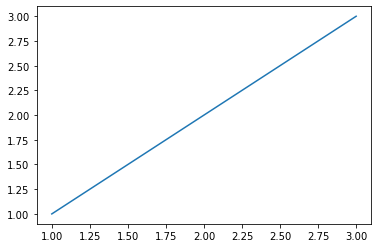

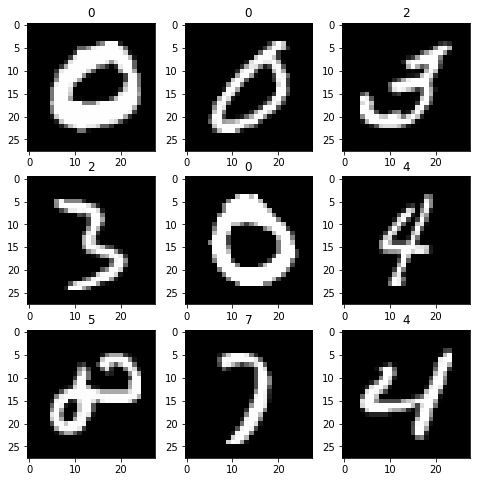

In [2]:

import matplotlib.pyplot as plt
plt.plot([1,2,3],[1,2,3])

import torch
from PBB.pbb.utils import runexp
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

BATCH_SIZE = 250
TRAIN_EPOCHS = 50
DELTA = 0.025
DELTA_TEST = 0.01
PRIOR = 'rand'

SIGMAPRIOR = 0.03

PMIN = 1e-5
KL_PENALTY = 0.1
LEARNING_RATE = 0.001
MOMENTUM = 0.95
LEARNING_RATE_PRIOR = 0.005
MOMENTUM_PRIOR = 0.99

# note the number of MC samples used in the paper is 150.000, which usually takes a several hours to compute
MC_SAMPLES = 1000

# note all of these running examples have different settings!

runexp('mnist', 'fquad', PRIOR, 'fcn', SIGMAPRIOR, PMIN, LEARNING_RATE, MOMENTUM, LEARNING_RATE_PRIOR, MOMENTUM_PRIOR, delta=DELTA, delta_test=DELTA_TEST, mc_samples=MC_SAMPLES, train_epochs=TRAIN_EPOCHS, device=DEVICE, perc_train=1.0, verbose=True, dropout_prob=0.2)
